### Importing libraries

In [63]:
import pandas as pd
import numpy as np
import pylab as p
import matplotlib.pyplot as plt
from collections import Counter
import re

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### Importing data
Data source: https://finance.yahoo.com/quote/BTC-USD/history/

The dataset contains the Bitcoin opening and closing prices between 2015-01-01 and 2022-03-31

In [64]:
df = pd.read_csv('coin_Bitcoin.csv')

In [65]:
df.tail()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11
2990,2991,Bitcoin,BTC,2021-07-06 23:59:59,35038.536363,33599.916169,33723.509655,34235.193451,2.650126e+10,6.418992e+11


In [66]:
df.describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2.991000e+03,2.991000e+03
mean,1496.000000,6893.326038,6486.009539,6700.146240,6711.290443,1.090633e+10,1.208761e+11
std,863.571653,11642.832456,10869.032130,11288.043736,11298.141921,1.888895e+10,2.109438e+11
min,1.000000,74.561096,65.526001,68.504997,68.431000,0.000000e+00,7.784112e+08
25%,748.500000,436.179001,422.879486,430.445496,430.569489,3.036725e+07,6.305579e+09
50%,1496.000000,2387.610107,2178.500000,2269.889893,2286.409912,9.460360e+08,3.741503e+10
75%,2243.500000,8733.926948,8289.800459,8569.656494,8576.238715,1.592015e+10,1.499957e+11
max,2991.000000,64863.098908,62208.964366,63523.754869,63503.457930,3.509679e+11,1.186364e+12


### Plotting the closing prices

In [67]:
cp = df[['Date','Close']]
cp['Date'] = pd.to_datetime(cp['Date'], format = '%Y-%m-%d')
#cp = cp.set_index('Date')
#cp.sort_index(inplace=True)

<AxesSubplot:xlabel='Date', ylabel='Close'>

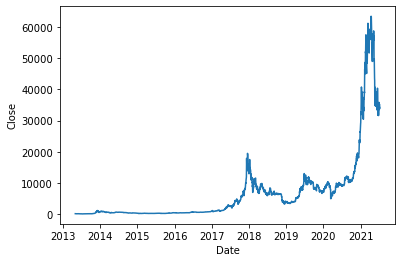

In [68]:
import seaborn as sns
fig,ax = plt.subplots()
sns.lineplot(data=cp, x='Date', y='Close', ax=ax)

### Checking Stationarity

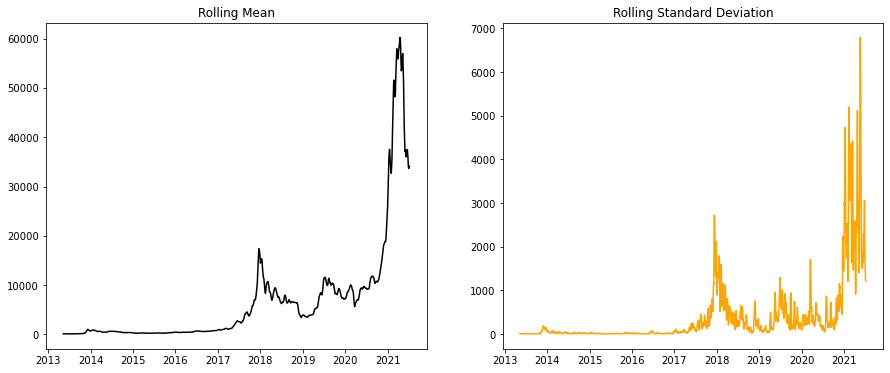

In [69]:
series = cp['Close']   
date = cp['Date']
#Determing rolling mean & standard deviation
rolmean = series.rolling(window=12,center=False).mean()
rolstd = series.rolling(window=12,center=False).std()

#Plot rolling statistics
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
ax1.plot(date,rolmean,color='black')
ax1.set_title("Rolling Mean")
ax2.plot(date,rolstd,color='orange')
ax2.set_title("Rolling Standard Deviation")
plt.show()

In [70]:
#Augmented Dicky Fuller Test:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(x):        
    result=adfuller(x)
    print(result)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    if pvalue >= 0.05:
        print("The graph is non stationary")
    else:
        print("The graph is stationary")


test_stationarity(series)

(-0.7973098451195643, 0.8199110033239141, 29, 2961, {'1%': -3.4325603944919445, '5%': -2.8625166073924957, '10%': -2.567289874591689}, 45929.032374699236)
ADF Stastistic: -0.797310
p-value: 0.819911
The graph is non stationary


### Making the time series stationary

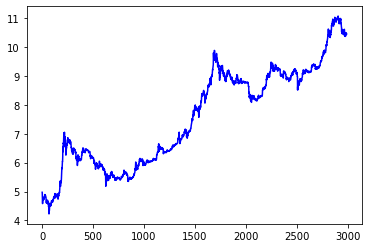

(-0.7766926675665871, 0.8258727405184354, 23, 2967, {'1%': -3.432555920657187, '5%': -2.8625146314725565, '10%': -2.5672888226314647}, -10304.074468791245)
ADF Stastistic: -0.776693
p-value: 0.825873
The graph is non stationary


In [71]:
#log-transforming the series
series_log = np.log(series)
plot.plot(series_log,color="blue")
plot.show()

test_stationarity(series_log)

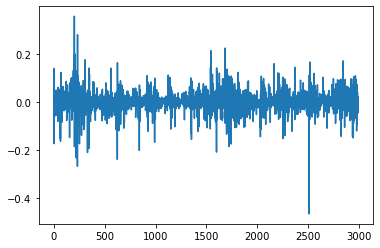

In [72]:
#removing trend and seasonality by differencing
series_log_diff = series_log - series_log.shift()
plot.plot(series_log_diff)
plot.show()

In [73]:
series_log_diff.dropna(inplace=True)
test_stationarity(series_log_diff)

(-10.394250782284034, 1.984170434468023e-18, 22, 2967, {'1%': -3.432555920657187, '5%': -2.8625146314725565, '10%': -2.5672888226314647}, -10301.26768194262)
ADF Stastistic: -10.394251
p-value: 0.000000
The graph is stationary


### The series is stationary after log transformation and differencing

### ARIMA for forecasting

In [74]:
from statsmodels.tsa.arima_model import ARIMA
cp['Year'] = pd.DatetimeIndex(cp['Date']).year

#Splitting train and test data

tr_l = 0.85*len(cp)
ts_l = len(cp) - tr_l

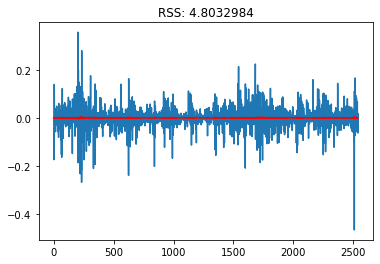

In [75]:
series_tr = series[:int(tr_l)]
series_log_tr = series_log[:int(tr_l)]
series_log_diff_tr = series_log_tr - series_log_tr.shift()
series_log_diff_tr.dropna(inplace=True)

series_ts = series[int(tr_l):]
series_log_ts = series_log[int(tr_l):]

model = ARIMA(series_log_tr, order=(2,1,0))  
results_ARIMA = model.fit(disp=-1)  
plot.plot(series_log_diff_tr)
plot.plot(results_ARIMA.fittedvalues, color='red')
plot.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-series_log_diff_tr)**2))
plot.show()

#### Evaluation using time-series cross validation (rolling forecasting origin)

Printing Forecasted vs Actual Values:


predicted = 6857.169457,   actual = 6842.427861,   error = 0.215444  %
predicted = 6853.117718,   actual = 6642.109893,   error = 3.176819  %
predicted = 6654.911125,   actual = 7116.804218,   error = 6.490176  %
predicted = 7121.237823,   actual = 7096.184659,   error = 0.353051  %
predicted = 7107.112837,   actual = 7257.664858,   error = 2.074387  %
predicted = 7266.736058,   actual = 7189.424824,   error = 1.075347  %
predicted = 7201.493791,   actual = 6881.958693,   error = 4.643084  %
predicted = 6896.773098,   actual = 6880.323474,   error = 0.239082  %
predicted = 6891.136205,   actual = 7117.207479,   error = 3.176404  %
predicted = 7124.916605,   actual = 7429.724649,   error = 4.102548  %
predicted = 7436.791234,   actual = 7550.901027,   error = 1.511208  %
predicted = 7560.853920,   actual = 7569.936034,   error = 0.119976  %
predicted = 7581.488974,   actual = 7679.867204,   error = 1.280989  %
predicted = 7690.490447,   actual = 7

predicted = 11696.495348,   actual = 11878.111325,   error = 1.528997  %
predicted = 11895.091045,   actual = 11410.525677,   error = 4.246652  %
predicted = 11436.385516,   actual = 11584.934576,   error = 1.282261  %
predicted = 11601.517991,   actual = 11784.137389,   error = 1.549705  %
predicted = 11800.976567,   actual = 11768.870619,   error = 0.272804  %
predicted = 11788.883294,   actual = 11865.698570,   error = 0.647373  %
predicted = 11884.181272,   actual = 11892.804063,   error = 0.072504  %
predicted = 11912.404851,   actual = 12254.401908,   error = 2.790810  %
predicted = 12269.678486,   actual = 11991.233246,   error = 2.322073  %
predicted = 12015.406272,   actual = 11758.283592,   error = 2.186737  %
predicted = 11781.357643,   actual = 11878.371621,   error = 0.816728  %
predicted = 11896.466038,   actual = 11592.489045,   error = 2.622189  %
predicted = 11616.070466,   actual = 11681.825562,   error = 0.562884  %
predicted = 11699.915473,   actual = 11664.847995, 

predicted = 19639.655478,   actual = 18802.998300,   error = 4.449595  %
predicted = 18847.212378,   actual = 19201.091157,   error = 1.843014  %
predicted = 19229.964490,   actual = 19445.398480,   error = 1.107892  %
predicted = 19476.389435,   actual = 18699.765613,   error = 4.153121  %
predicted = 18743.814971,   actual = 19154.231131,   error = 2.142692  %
predicted = 19182.136290,   actual = 19345.120959,   error = 0.842510  %
predicted = 19376.507142,   actual = 19191.631287,   error = 0.963315  %
predicted = 19228.107827,   actual = 18321.144916,   error = 4.950362  %
predicted = 18366.519914,   actual = 18553.915377,   error = 1.010005  %
predicted = 18584.177094,   actual = 18264.992107,   error = 1.747523  %
predicted = 18301.457268,   actual = 18058.903347,   error = 1.343127  %
predicted = 18094.101901,   actual = 18803.656870,   error = 3.773495  %
predicted = 18825.762575,   actual = 19142.382534,   error = 1.654026  %
predicted = 19170.589092,   actual = 19246.644341, 

predicted = 55204.516629,   actual = 55973.510842,   error = 1.373854  %
predicted = 56082.690275,   actual = 55950.745774,   error = 0.235823  %
predicted = 56068.651631,   actual = 57750.199871,   error = 2.911762  %
predicted = 57847.578352,   actual = 58917.693045,   error = 1.816287  %
predicted = 59028.199553,   actual = 58918.832714,   error = 0.185623  %
predicted = 59043.903275,   actual = 59095.807978,   error = 0.087831  %
predicted = 59217.920047,   actual = 59384.313359,   error = 0.280197  %
predicted = 59505.802322,   actual = 57603.889174,   error = 3.301710  %
predicted = 57747.549243,   actual = 58758.556291,   error = 1.720612  %
predicted = 58865.147804,   actual = 59057.878966,   error = 0.326343  %
predicted = 59179.161517,   actual = 58192.358684,   error = 1.695760  %
predicted = 58325.841240,   actual = 56048.937813,   error = 4.062349  %
predicted = 56192.220025,   actual = 58323.953580,   error = 3.654988  %
predicted = 58414.036445,   actual = 58245.003001, 

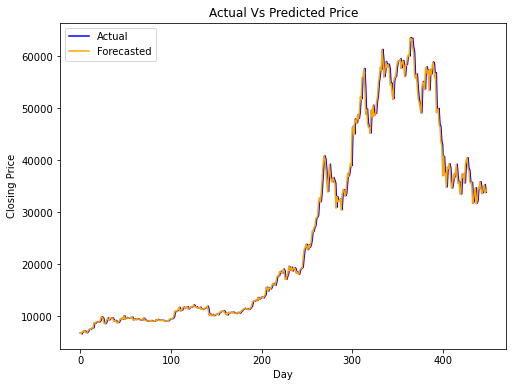

In [76]:
train_list = [x for x in series_log_tr]
test_list = [y for y in series_log_ts]
prediction = list()
close = list()
error = list()

print('Printing Forecasted vs Actual Values:')
print('\n')

for i in range(len(series_log_ts)):
    model = ARIMA(train_list, order=(2, 1, 0))
    model_fit = model.fit(disp=-1)
    
    output = model_fit.forecast()
    
    pred = output[0]   
    act = test_list[i]
    train_list.append(act)
    pred = np.exp(pred)
    act = np.exp(act)
    
    # Calculating the error
    error_val = ((abs(pred - act)) / act) * 100
    error.append(error_val)
    print('predicted = %f,   actual = %f,   error = %f ' % (pred, act, error_val), '%')
    
    prediction.append(float(pred))
    close.append(float(act))
    
# Overall mean error   
print('\n Mean Error: %f ' % (sum(error)/float(len(error))), '%')
plot.figure(figsize=(8, 6))
test_day = [y for y in range(len(series_log_ts))]
labels={'Actual','Forecasted'}
plot.plot(test_day, prediction, color= 'blue')
plot.plot(test_day, close, color = 'orange')
plot.title('Actual Vs Predicted Price')
plot.xlabel('Day')
plot.ylabel('Closing Price')
plot.legend(labels)
plot.show()